# Clifin EDA

Exploratory Data Analysis for Clifin transactions data

In [33]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("Libs imported successfully!")

Libs imported successfully!


## Data Loading

Connect to the SQLite database and load transaction data into a pandas DataFrame

In [34]:
def load_transaction_data():
    conn = sqlite3.connect("clifin.db")

    df = pd.read_sql_query(
        """
        SELECT 
            id,
            title,
            amount,
            category,
            description,
            date,
            created_at
        FROM transactions 
        ORDER BY date DESC
    """,
        conn,
    )

    conn.close()
    return df


df = load_transaction_data()

print(f"Dataset loaded: {df.shape[0]} transactions, {df.shape[1]} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total balance: ${df['amount'].sum():.2f}")

Dataset loaded: 201 transactions, 7 columns
Date range: 2024-11-14 to 2025-11-10
Total balance: $68888.90


## Data Preprocessing

Clean and prepare data

In [35]:
def preprocess_data(df):
    df_processed = df.copy()

    # Convert date columns to datetime
    df_processed["date"] = pd.to_datetime(df_processed["date"])
    df_processed["created_at"] = pd.to_datetime(df_processed["created_at"])

    # Create additional date features
    df_processed["year"] = df_processed["date"].dt.year
    df_processed["month"] = df_processed["date"].dt.month
    df_processed["month_name"] = df_processed["date"].dt.month_name()
    df_processed["day_of_week"] = df_processed["date"].dt.day_name()
    df_processed["week"] = df_processed["date"].dt.isocalendar().week

    # Create transaction type
    df_processed["type"] = df_processed["amount"].apply(
        lambda x: "Revenue" if x >= 0 else "Expense"
    )
    df_processed["abs_amount"] = df_processed["amount"].abs()

    # Create month-year column for time series
    df_processed["month_year"] = df_processed["date"].dt.to_period("M")

    return df_processed


# Preprocess the data
df_processed = preprocess_data(df)
print("Data preprocessing completed")
print(f"Processed dataset shape: {df_processed.shape}")
print("New columns added:")
new_cols = [col for col in df_processed.columns if col not in df.columns]
for col in new_cols:
    print(f"  - {col}")

Data preprocessing completed
Processed dataset shape: (201, 15)
New columns added:
  - year
  - month
  - month_name
  - day_of_week
  - week
  - type
  - abs_amount
  - month_year


## Data Overview

In [36]:
# Basic data overview
print("Dataframe Overview")
print("=" * 50)
print(df_processed.info())
print("\n" + "=" * 50)
print("\nBasic Statistics")
print("=" * 50)
print(df_processed.describe())

# Check for missing values
print("\nMissing Values")
print("=" * 50)
missing_data = df_processed.isnull().sum()
print(missing_data[missing_data > 0])

Dataframe Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           201 non-null    int64         
 1   title        201 non-null    object        
 2   amount       201 non-null    float64       
 3   category     201 non-null    object        
 4   description  63 non-null     object        
 5   date         201 non-null    datetime64[ns]
 6   created_at   201 non-null    datetime64[ns]
 7   year         201 non-null    int32         
 8   month        201 non-null    int32         
 9   month_name   201 non-null    object        
 10  day_of_week  201 non-null    object        
 11  week         201 non-null    UInt32        
 12  type         201 non-null    object        
 13  abs_amount   201 non-null    float64       
 14  month_year   201 non-null    period[M]     
dtypes: UInt32(1), datetime64[ns](2), float

## 1. Transaction Distribution

Distribution of revenues vs expenses

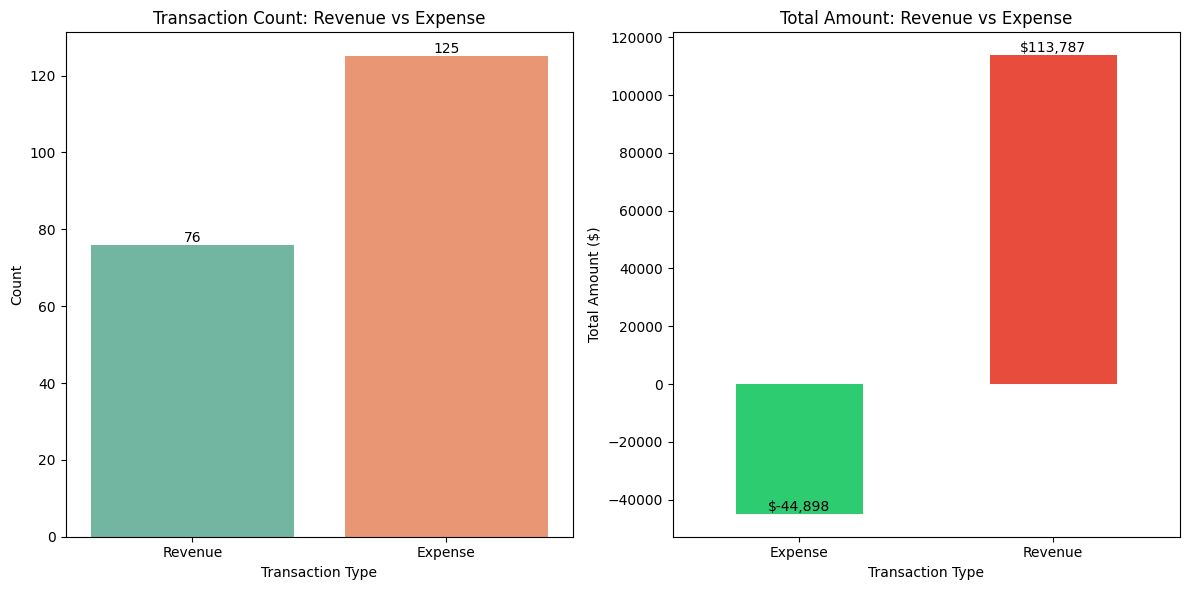


Financial Summary
Total Revenue: $113,786.90
Total Expenses: $44,898.00
Net Balance: $68,888.90
Savings Rate: 60.5%


In [37]:
# Transaction types distribution
plt.figure(figsize=(12, 6))

# Count plot
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df_processed, x="type", palette="Set2")
plt.title("Transaction Count: Revenue vs Expense")
plt.xlabel("Transaction Type")
plt.ylabel("Count")

# Add count labels
for p in ax1.patches:
    ax1.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

# Amount distribution
plt.subplot(1, 2, 2)
type_amounts = df_processed.groupby("type")["amount"].sum()
ax2 = type_amounts.plot(kind="bar", color=["#2ecc71", "#e74c3c"])
plt.title("Total Amount: Revenue vs Expense")
plt.xlabel("Transaction Type")
plt.ylabel("Total Amount ($)")
plt.xticks(rotation=0)

# Add amount labels
for p in ax2.patches:
    ax2.annotate(
        f"${p.get_height():,.0f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Summary statistics
print("\nFinancial Summary")
print("=" * 30)
total_revenue = df_processed[df_processed["type"] == "Revenue"]["amount"].sum()
total_expenses = df_processed[df_processed["type"] == "Expense"]["amount"].sum()
net_balance = total_revenue + total_expenses

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Expenses: ${abs(total_expenses):,.2f}")
print(f"Net Balance: ${net_balance:,.2f}")
print(
    f"Savings Rate: {(total_revenue - abs(total_expenses)) / total_revenue * 100:.1f}%"
)

## 2. Category Analysis

Spending and income patterns by category

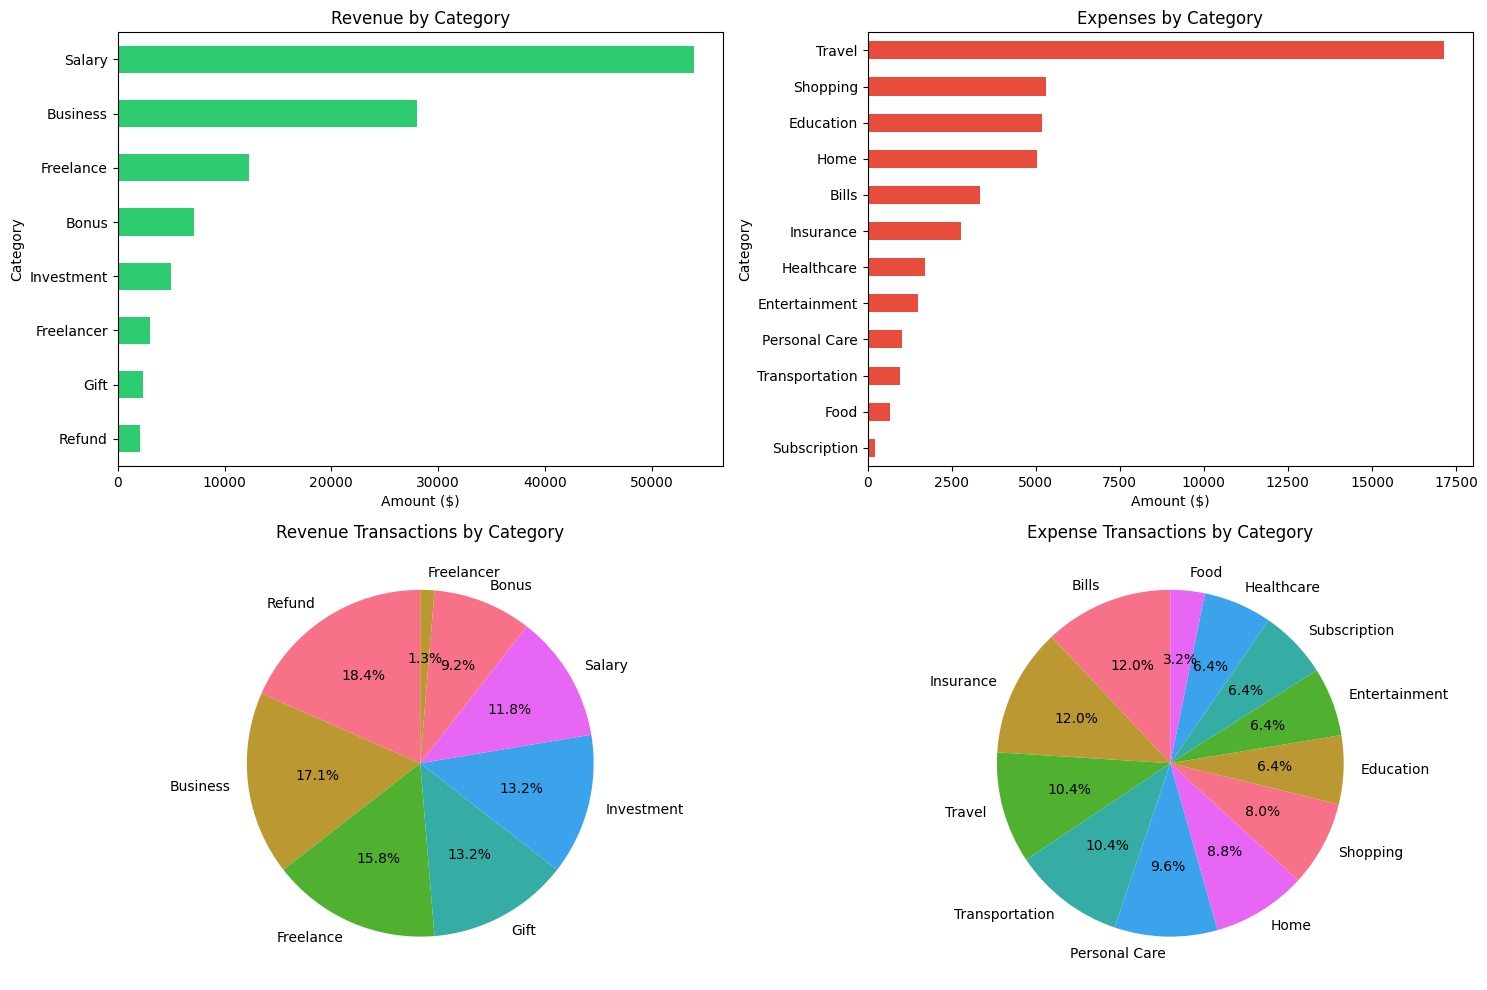


Top Categories

Top Revenue Categories:
  Salary: $53,935.47
  Business: $27,994.16
  Freelance: $12,298.97

Top Expense Categories:
  Travel: $17,147.31
  Shopping: $5,316.73
  Education: $5,199.73


In [38]:
# Category analysis
plt.figure(figsize=(15, 10))

# Revenue by category
plt.subplot(2, 2, 1)
revenue_by_cat = (
    df_processed[df_processed["type"] == "Revenue"]
    .groupby("category")["amount"]
    .sum()
    .sort_values(ascending=True)
)
revenue_by_cat.plot(kind="barh", color="#2ecc71")
plt.title("Revenue by Category")
plt.xlabel("Amount ($)")
plt.ylabel("Category")

# Expenses by category
plt.subplot(2, 2, 2)
expense_by_cat = (
    df_processed[df_processed["type"] == "Expense"]
    .groupby("category")["amount"]
    .sum()
    .abs()
    .sort_values(ascending=True)
)
expense_by_cat.plot(kind="barh", color="#e74c3c")
plt.title("Expenses by Category")
plt.xlabel("Amount ($)")
plt.ylabel("Category")

# Category frequency - Revenue
plt.subplot(2, 2, 3)
revenue_freq = df_processed[df_processed["type"] == "Revenue"][
    "category"
].value_counts()
revenue_freq.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Revenue Transactions by Category")
plt.ylabel("")

# Category frequency - Expenses
plt.subplot(2, 2, 4)
expense_freq = df_processed[df_processed["type"] == "Expense"][
    "category"
].value_counts()
expense_freq.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Expense Transactions by Category")
plt.ylabel("")

plt.tight_layout()
plt.show()

# Top categories summary
print("\nTop Categories")
print("=" * 30)
print("\nTop Revenue Categories:")
for cat, amount in revenue_by_cat.nlargest(3).items():
    print(f"  {cat}: ${amount:,.2f}")

print("\nTop Expense Categories:")
for cat, amount in expense_by_cat.nlargest(3).items():
    print(f"  {cat}: ${amount:,.2f}")

## 3. Time Series Analysis

How finances change over time

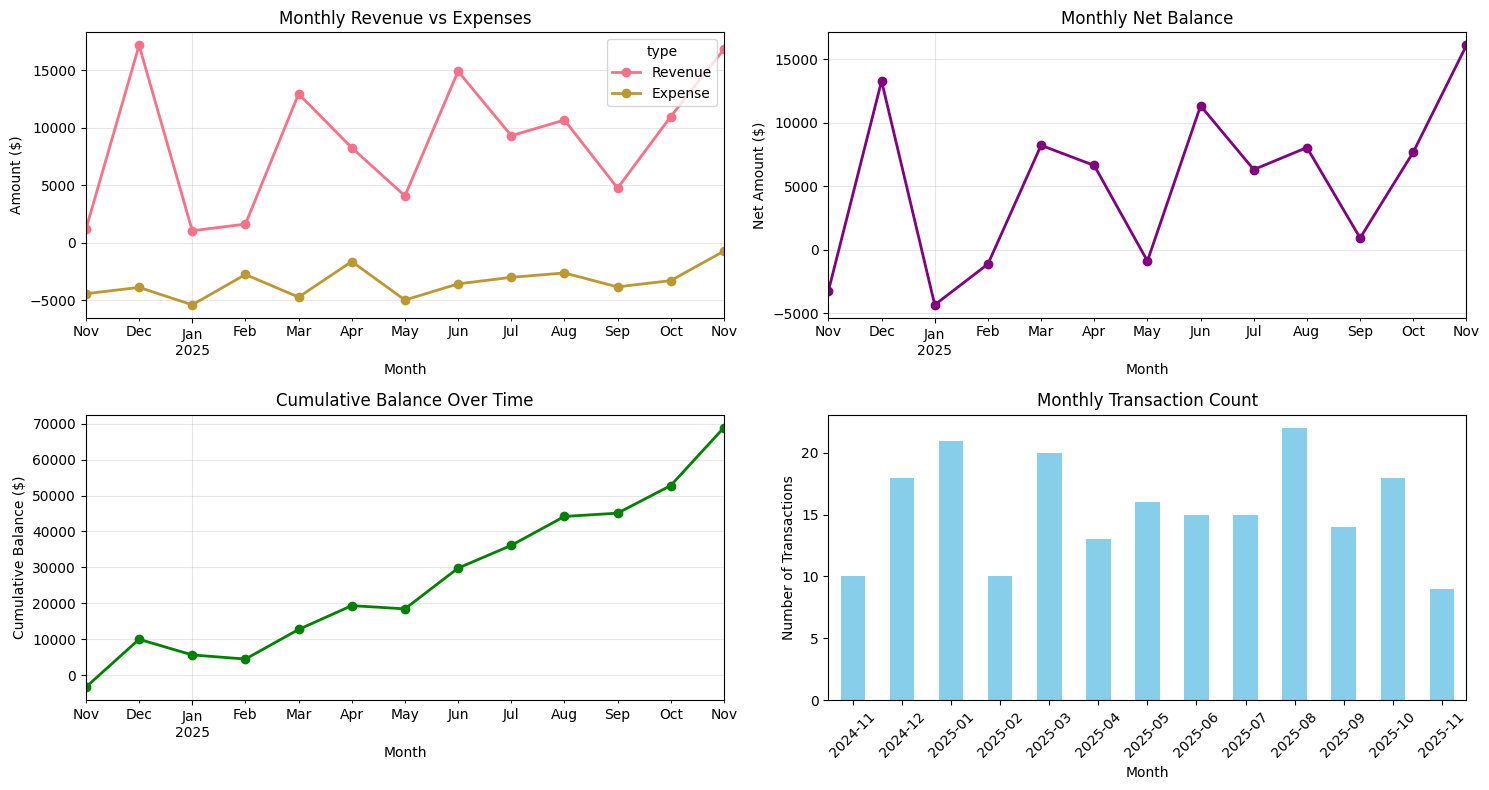


Time Series Summary
Average monthly revenue: $8,752.84
Average monthly expenses: $3,453.69
Average monthly net: $5,299.15
Best month: 2025-11 ($16,105.14)
Worst month: 2025-01 ($-4,352.44)


In [39]:
# Time series analysis
monthly_data = (
    df_processed.groupby(["month_year", "type"])["amount"].sum().unstack().fillna(0)
)
monthly_data["net"] = monthly_data.get("Revenue", 0) + monthly_data.get("Expense", 0)

# Monthly trends
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Revenue vs Expense
ax1 = axes[0, 0]
monthly_data[["Revenue", "Expense"]].plot(
    kind="line",
    marker="o",
    linewidth=2,
    ax=ax1,
)
ax1.set_title("Monthly Revenue vs Expenses")
ax1.set_xlabel("Month")
ax1.set_ylabel("Amount ($)")
ax1.grid(True, alpha=0.3)

# Net balance
ax2 = axes[0, 1]
monthly_data["net"].plot(kind="line", marker="o", color="purple", linewidth=2, ax=ax2)
ax2.set_title("Monthly Net Balance")
ax2.set_xlabel("Month")
ax2.set_ylabel("Net Amount ($)")
ax2.grid(True, alpha=0.3)

# Cumulative balance
ax3 = axes[1, 0]
cumulative_balance = monthly_data["net"].cumsum()
cumulative_balance.plot(kind="line", marker="o", color="green", linewidth=2, ax=ax3)
ax3.set_title("Cumulative Balance Over Time")
ax3.set_xlabel("Month")
ax3.set_ylabel("Cumulative Balance ($)")
ax3.grid(True, alpha=0.3)

# Monthly transaction count
ax4 = axes[1, 1]
monthly_count = df_processed.groupby("month_year").size()
monthly_count.plot(kind="bar", color="skyblue", ax=ax4)
ax4.set_title("Monthly Transaction Count")
ax4.set_xlabel("Month")
ax4.set_ylabel("Number of Transactions")
ax4.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Time series statistics
print("\nTime Series Summary")
print("=" * 30)
print(f"Average monthly revenue: ${monthly_data['Revenue'].mean():,.2f}")
print(f"Average monthly expenses: ${abs(monthly_data['Expense'].mean()):,.2f}")
print(f"Average monthly net: ${monthly_data['net'].mean():,.2f}")
print(f"Best month: {monthly_data['net'].idxmax()} (${monthly_data['net'].max():,.2f})")
print(
    f"Worst month: {monthly_data['net'].idxmin()} (${monthly_data['net'].min():,.2f})"
)

## 4. Amount Distribution Analysis

Distribution of transaction amounts

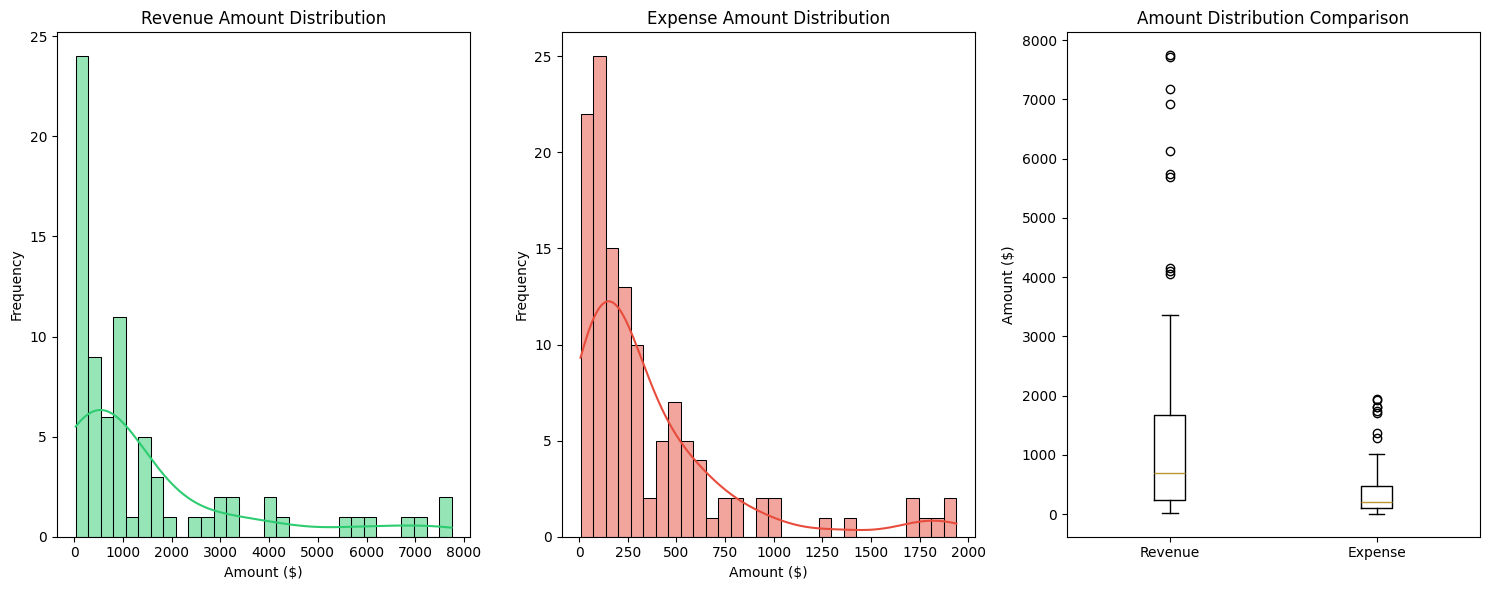


Amount Distribution Statistics

Revenue:
count      76.000000
mean     1497.196053
std      1976.316275
min        27.070000
25%       247.010000
50%       694.110000
75%      1677.955000
max      7745.990000
Name: amount, dtype: float64

Expenses:
count     125.000000
mean      359.184000
std       424.701046
min         7.410000
25%       106.550000
50%       201.670000
75%       477.990000
max      1938.030000
Name: abs_amount, dtype: float64


In [40]:
# Amount distribution analysis
plt.figure(figsize=(15, 6))

# Revenue amount distribution
plt.subplot(1, 3, 1)
revenue_amounts = df_processed[df_processed["type"] == "Revenue"]["amount"]
sns.histplot(revenue_amounts, bins=30, kde=True, color="#2ecc71")
plt.title("Revenue Amount Distribution")
plt.xlabel("Amount ($)")
plt.ylabel("Frequency")

# Expense amount distribution
plt.subplot(1, 3, 2)
expense_amounts = df_processed[df_processed["type"] == "Expense"]["abs_amount"]
sns.histplot(expense_amounts, bins=30, kde=True, color="#e74c3c")
plt.title("Expense Amount Distribution")
plt.xlabel("Amount ($)")
plt.ylabel("Frequency")

# Box plot comparison
plt.subplot(1, 3, 3)
amount_data = [
    df_processed[df_processed["type"] == "Revenue"]["amount"],
    df_processed[df_processed["type"] == "Expense"]["abs_amount"],
]
plt.boxplot(amount_data, labels=["Revenue", "Expense"])
plt.title("Amount Distribution Comparison")
plt.ylabel("Amount ($)")

plt.tight_layout()
plt.show()

# Distribution statistics
print("\nAmount Distribution Statistics")
print("=" * 40)
print("\nRevenue:")
print(revenue_amounts.describe())
print("\nExpenses:")
print(expense_amounts.describe())

## 5. Correlation Analysis

Correlations between different variables

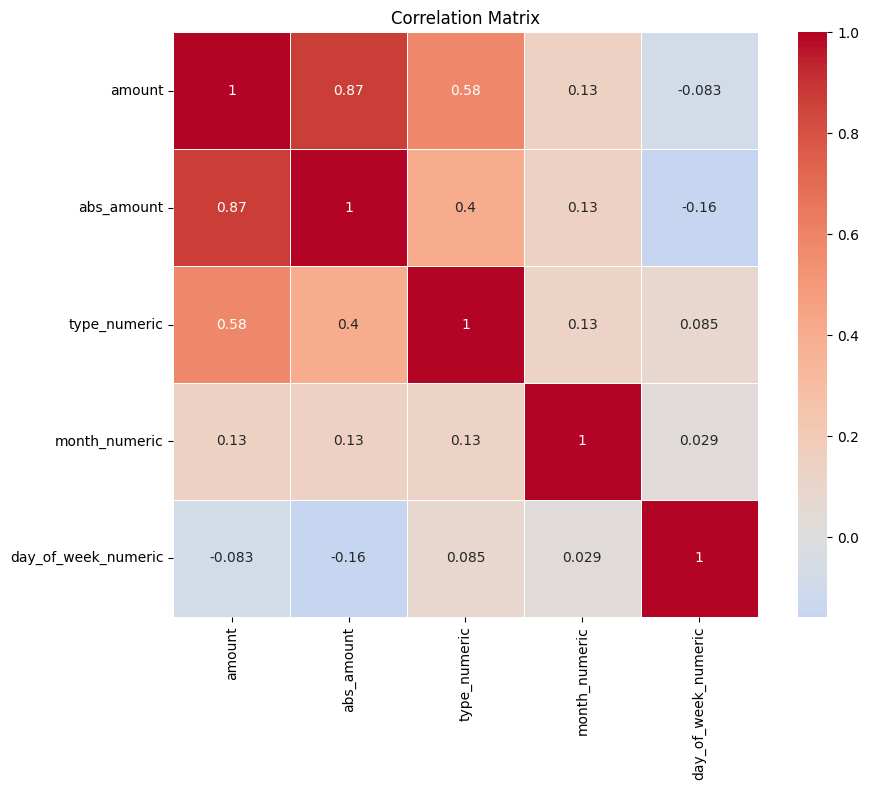


Key Correlations

Strongest correlations with amount:
  abs_amount: 0.873
  type_numeric: 0.584
  month_numeric: 0.133
  day_of_week_numeric: -0.083


In [41]:
# Create numerical features for correlation
df_corr = df_processed.copy()
df_corr["type_numeric"] = df_corr["type"].map({"Revenue": 1, "Expense": 0})
df_corr["month_numeric"] = df_corr["month"]
df_corr["day_of_week_numeric"] = df_corr["date"].dt.dayofweek

# Select numerical columns for correlation
numerical_cols = [
    "amount",
    "abs_amount",
    "type_numeric",
    "month_numeric",
    "day_of_week_numeric",
]
correlation_matrix = df_corr[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Display correlation values
print("\nKey Correlations")
print("=" * 30)
print("\nStrongest correlations with amount:")
amount_corr = correlation_matrix["amount"].abs().sort_values(ascending=False)
for col, corr in amount_corr[1:6].items():  # Skip self-correlation
    print(f"  {col}: {correlation_matrix.loc['amount', col]:.3f}")

## 6. Spendings over time

Average monthly expenses and top 5 expense categories over time

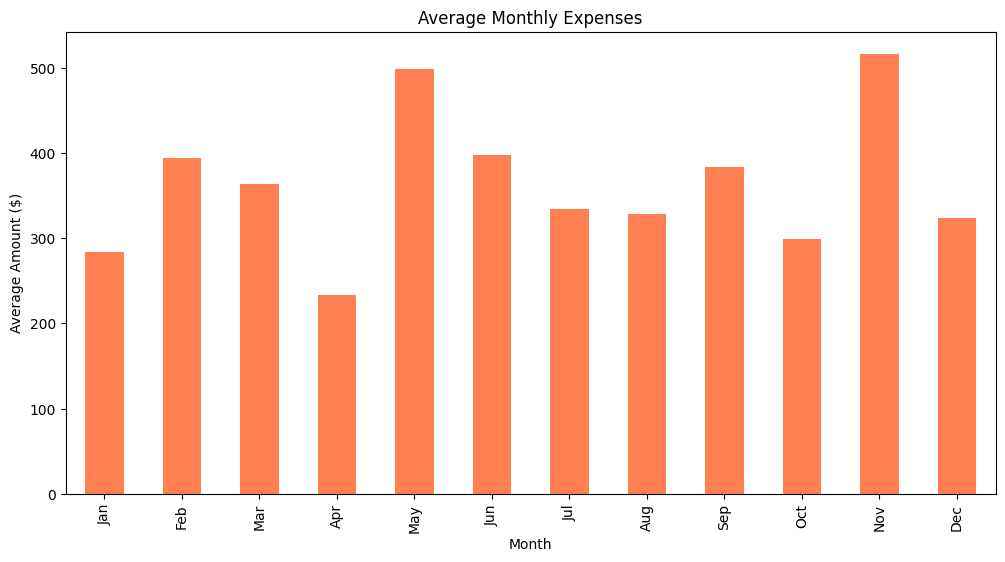

<Figure size 1400x800 with 0 Axes>

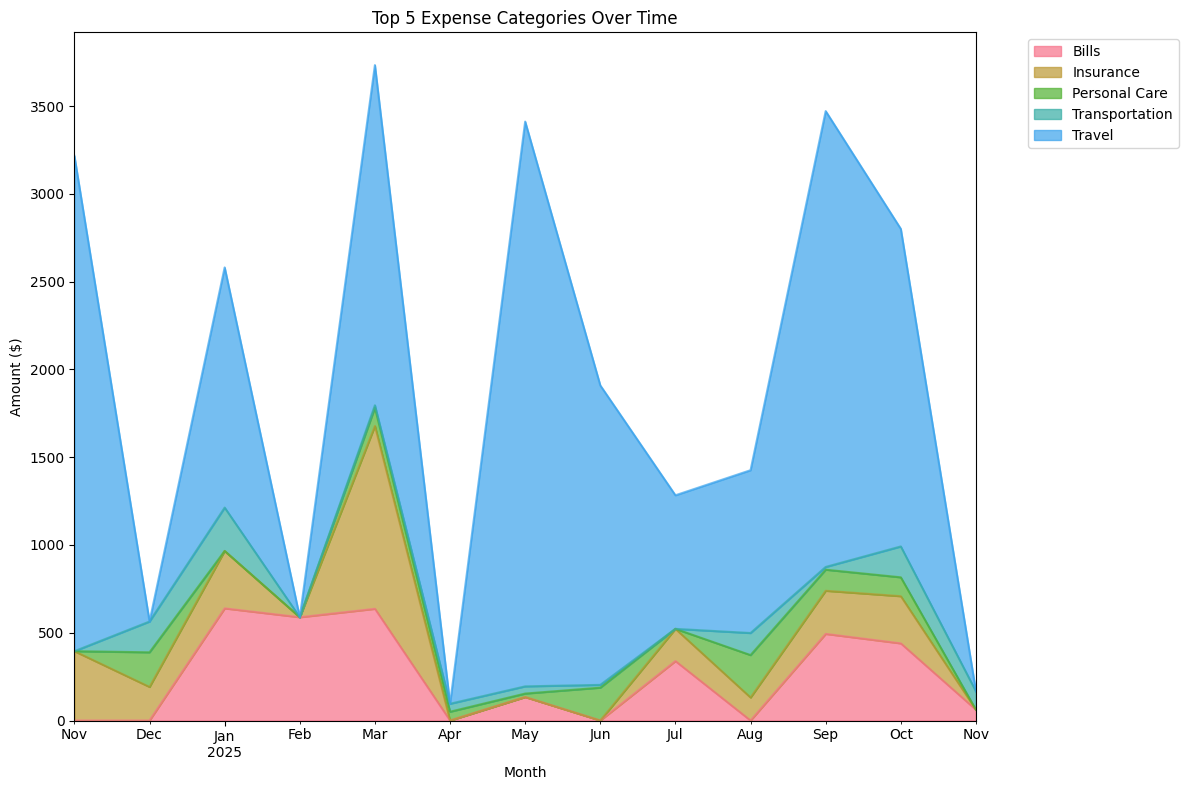

In [42]:
# Seasonal spending patterns
plt.figure(figsize=(12, 6))
monthly_expenses = (
    df_processed[df_processed["type"] == "Expense"]
    .groupby("month")["abs_amount"]
    .mean()
)
monthly_expenses.plot(kind="bar", color="coral")
plt.title("Average Monthly Expenses")
plt.xlabel("Month")
plt.ylabel("Average Amount ($)")
plt.xticks(
    range(12),
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
)
plt.show()

# Category spending over time
plt.figure(figsize=(14, 8))
top_categories = (
    df_processed[df_processed["type"] == "Expense"]["category"]
    .value_counts()
    .head(5)
    .index
)
category_time = (
    df_processed[df_processed["category"].isin(top_categories)]
    .pivot_table(
        values="abs_amount", index="month_year", columns="category", aggfunc="sum"
    )
    .fillna(0)
)
category_time.plot(kind="area", stacked=True, alpha=0.7)
plt.title("Top 5 Expense Categories Over Time")
plt.xlabel("Month")
plt.ylabel("Amount ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 7. Summary

In [43]:
print("🎯 Key Insights")
print("=" * 50)

# Financial health metrics
total_transactions = len(df_processed)
revenue_transactions = len(df_processed[df_processed["type"] == "Revenue"])
expense_transactions = len(df_processed[df_processed["type"] == "Expense"])

print(f"📊 Total Transactions: {total_transactions}")
print(
    f"💚 Revenue Transactions: {revenue_transactions} ({revenue_transactions / total_transactions * 100:.1f}%)"
)
print(
    f"❤️ Expense Transactions: {expense_transactions} ({expense_transactions / total_transactions * 100:.1f}%)"
)

# Top categories
top_revenue_cat = (
    df_processed[df_processed["type"] == "Revenue"]
    .groupby("category")["amount"]
    .sum()
    .idxmax()
)
top_expense_cat = (
    df_processed[df_processed["type"] == "Expense"]
    .groupby("category")["abs_amount"]
    .sum()
    .idxmax()
)

print(f"\n🏆 Top Revenue Category: {top_revenue_cat}")
print(f"🏆 Top Expense Category: {top_expense_cat}")

# Monthly patterns
best_month = monthly_data["net"].idxmax()
worst_month = monthly_data["net"].idxmin()

print(f"\n📈 Best Month: {best_month} (${monthly_data.loc[best_month, 'net']:,.2f})")
print(f"📉 Worst Month: {worst_month} (${monthly_data.loc[worst_month, 'net']:,.2f})")

# Recommendations
avg_monthly_net = monthly_data["net"].mean()
if avg_monthly_net > 0:
    print(
        f"\n✅ Positive cash flow: Average monthly surplus of ${avg_monthly_net:,.2f}"
    )
else:
    print(
        f"\n⚠️ Negative cash flow: Average monthly deficit of ${abs(avg_monthly_net):,.2f}"
    )

🎯 Key Insights
📊 Total Transactions: 201
💚 Revenue Transactions: 76 (37.8%)
❤️ Expense Transactions: 125 (62.2%)

🏆 Top Revenue Category: Salary
🏆 Top Expense Category: Travel

📈 Best Month: 2025-11 ($16,105.14)
📉 Worst Month: 2025-01 ($-4,352.44)

✅ Positive cash flow: Average monthly surplus of $5,299.15
